<a href="https://colab.research.google.com/github/OVP2023/NLP/blob/main/NLP_DZ1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.3 MB/s eta 0:00:00


In [ ]:
responses = []
with bz2.BZ2File('/content/drive/MyDrive/Datasets/NLP/DZ1/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)



201030it [02:08, 1562.80it/s]


In [ ]:
df=pd.DataFrame(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
'''Анализ текста
1.1. Посчитайте количество отзывов в разных городах и на разные банки
1.2. Постройте гистограмы длин слов в символах и в словах
1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных
1.4. Постройте кривые Ципфа и Хипса
1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и
"доверие"?
1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и
биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)'''

In [ ]:
#1.1. Посчитайте количество отзывов в разных городах и на разные банки
df_city=df['city'].value_counts(dropna=False)
print(df_city)


city
г. Москва                                 55354
None                                      15174
г. Санкт-Петербург                        14342
г. Екатеринбург                            2337
г. Новосибирск                             2300
                                          ...  
г. Ленинск-кузнецкий                          1
г. Шемышейка                                  1
г. Саратов Саратовской области                1
г. Облучье (Еврейская автономная обл.)        1
г. Москва + Санкт-Петербург                   1
Name: count, Length: 5824, dtype: int64


In [ ]:
df_bank=df['bank_name'].value_counts(dropna=False)
print(df_bank)

bank_name
Сбербанк России                  26327
Альфа-Банк                       10224
ВТБ 24                            8185
Русский Стандарт                  7943
Хоум Кредит Банк                  7549
                                 ...  
Фемили                               1
Современные Стандарты Бизнеса        1
Нэклис-Банк                          1
Жилстройбанк                         1
Юго-Восток                           1
Name: count, Length: 670, dtype: int64


In [1]:
list_text=df['text'].tolist()

NameError: name 'df' is not defined

In [ ]:
#Средняя длина текстов в символах 1554, максимальное количество символов в тексте 32082, всего текстов 153499
len_data = df['text'].apply(len)
len_data.describe()

,text
count,153499.000000
mean,1554.212790
std,1319.098042
min,23.000000
25%,732.000000
50%,1193.000000
75%,1929.000000
max,32082.000000


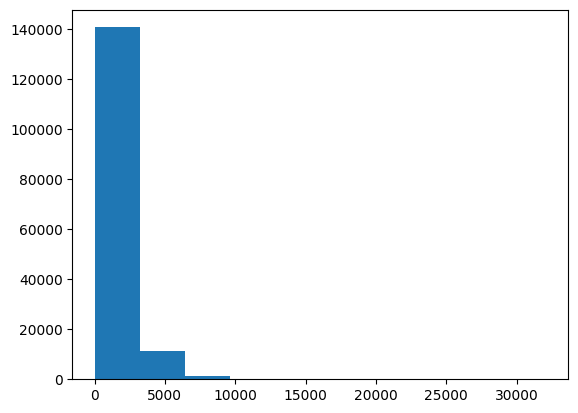

In [ ]:
#1.2 Гистограмма длины текстов в символах
fig, ax = plt.subplots()
length = len_data.tolist()
n, bins, patches = ax.hist(length)
fig.show()

In [ ]:
#Функция подсчета 10 наиболее встречающихся слов
from collections import Counter
from tqdm import tqdm_notebook as tqdm

def  word_count(col_name):
   cnt = Counter()
   n_types = []
   n_tokens = []
   tokens = []
   for index, row in tqdm(df.iterrows(), total = len(df)):
       tokens = row[col_name].split()
       cnt.update(tokens)
       n_types.append(len(cnt))
       n_tokens.append(sum(cnt.values()))
   for i in cnt.most_common(10):
       print(i)

#Функция удаления стоп слов из текста
from nltk.corpus import stopwords

nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['на', 'что', '-', 'и',  'я', 'по','Я','Вы']

def  remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

#Функция лемматизации текста
import pymorphy3

m = pymorphy3.MorphAnalyzer()

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()
    except:
        return " "

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#1.3 Найдем самые частые слова не меняя оригинальный текст
word_count('text')

<ipython-input-12-85ac2db966ae>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('в', 1157262)
('и', 965735)
('не', 808409)
('на', 632541)
('что', 586864)
('я', 427944)
('с', 423586)
('по', 333342)
('-', 294086)
('мне', 277035)


In [ ]:
#Найдем самые частые слова без стоп-слов
df['stopwords']= df.text.apply(remove_stopwords)
word_count('stopwords')

<ipython-input-12-85ac2db966ae>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('В', 150939)
('это', 149096)
('банка', 142787)
('банк', 108339)
('деньги', 88936)
('И', 70944)
('карты', 63335)
('карту', 63213)
('На', 62779)
('очень', 51299)


In [ ]:
#Найдем самые частые леммы после исключения стоп слов
df['lemma'] = df.stopwords.apply(lemmatize)
word_count('lemma')

<ipython-input-12-85ac2db966ae>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df.iterrows(), total = len(df)):


  0%|          | 0/153499 [00:00<?, ?it/s]

('банк', 395662)
('карта', 219718)
('это', 187914)
('мой', 171085)
('в', 154254)
('который', 142638)
('деньга', 128634)
('отделение', 109285)
('сотрудник', 109248)
('свой', 100649)


In [ ]:
df.head(5)



,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,stopwords,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Добрый день! являюсь клиентом банка поручителе...,добрый день! являться клиент банк поручитель к...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Доброго дня! Являюсь держателем зарплатной кар...,добрый дня! являться держатель зарплатный карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Здравствуйте! Дублирую свое заявление 03.06.20...,здравствуйте! дублировать свой заявление 03.06...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"Добрый день!! открыл расчетный счет СберБанке,...",добрый день!! открыть расчётный счёт сбербанке...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"04.03.2015 г. взяла кредит вашем банке, заявле...","04.03.2015 г. взять кредит ваш банке, заявить ..."


In [ ]:
df.to_parquet('/content/drive/MyDrive/Datasets/NLP/df_file.zstd',
              compression='zstd')

In [ ]:
dfpar=pd.read_parquet('/content/drive/MyDrive/Datasets/NLP/df_file.zstd')

In [ ]:
dfpar.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,stopwords,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Добрый день! являюсь клиентом банка поручителе...,добрый день! являться клиент банк поручитель к...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Доброго дня! Являюсь держателем зарплатной кар...,добрый дня! являться держатель зарплатный карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Здравствуйте! Дублирую свое заявление 03.06.20...,здравствуйте! дублировать свой заявление 03.06...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"Добрый день!! открыл расчетный счет СберБанке,...",добрый день!! открыть расчётный счёт сбербанке...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"04.03.2015 г. взяла кредит вашем банке, заявле...","04.03.2015 г. взять кредит ваш банке, заявить ..."


In [ ]:
#1.4 Кривая Ципфа
cnt = Counter()
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()



In [ ]:
#Кривая Хипса
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [ ]:
'''2. Тематическое моделирование
2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем
2.2. Приведите примеры понятных (интерпретируемых) тем
2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать /объяснить'''

In [ ]:
#2.1. Построим модель тематического моделирования с помощью библиотеки bertopic

In [ ]:
# Choose an embedding backend
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic()

#texts = [text.split() for text in dfpar.lemma]
list_text=dfpar['lemma'].tolist()
list_k=[] #Для сокращения времени обработаем первые 1000 текстов
for i in range(1000):
    list_k.append(list_text[i])
topics, probs = topic_model.fit_transform(list_k)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,947,0_2015_000_10_15,"[2015, 000, 10, 15, 24, 30, 20, 2014, 25, 12]",[наличие расчётный счёт данный банк пользовани...
1,1,27,1_bankiru_cash_back_29,"[bankiru, cash, back, 29, bank, 25102013, 21, ...","[этот отзыв предупреждение тем, хотеть стать к..."
2,2,26,2_visa_card_gold_classic,"[visa, card, gold, classic, 000, mastercard, e...","[уважаемый технический поддержка, просить вы п..."


In [ ]:
topic_model.get_topic(1)

[('bankiru', 0.1482992301763789),
 ('cash', 0.12854398737430214),
 ('back', 0.12854398737430214),
 ('29', 0.08909431453102015),
 ('bank', 0.0828221810699888),
 ('25102013', 0.0828221810699888),
 ('21', 0.06705384045595682),
 ('05jpg', 0.06503655862490287),
 ('071jpg', 0.06503655862490287),
 ('06jpg', 0.06503655862490287)]

In [ ]:
#Создадим вторую модель тематического моделирование с помощью библиотеки gensim, После запуска !pip install gensim   необходимо перезапустить сеанс и только после этого запускать импорт из gensim

In [ ]:
!pip install gensim -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [ ]:
#После запуска !pip install gensim   необходимо перезапустить сеанс и только после этого запускать инмпорт из gensim

texts = [text.split() for text in dfpar.lemma]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)


CPU times: user 11min 27s, sys: 39.8 s, total: 12min 7s
Wall time: 8min 17s


In [ ]:
lsi.show_topics(10)

[(0,
  '0.158*"карта" + 0.104*"кредит" + 0.104*"деньга" + 0.096*"мой" + 0.094*"заявление" + 0.093*"счёт" + 0.093*"кредитный" + 0.091*"отделение" + 0.090*"сотрудник" + 0.087*"сумма"'),
 (1,
  '0.319*"кредит" + -0.251*"вклад" + -0.226*"банкомат" + -0.208*"карта" + -0.145*"деньга" + 0.134*"погашение" + 0.131*"ваш" + 0.127*"звонок" + 0.127*"кредитный" + 0.121*"договор"'),
 (2,
  '-0.365*"вклад" + 0.238*"банкомат" + 0.191*"карта" + 0.162*"заявление" + 0.147*"средство" + 0.145*"сбербанк" + 0.142*"денежный" + 0.126*"деньга" + -0.110*"очередь" + -0.108*"открыть"'),
 (3,
  '-0.332*"вклад" + 0.227*"номер" + -0.210*"сумма" + -0.176*"договор" + 0.165*"звонок" + -0.145*"досрочный" + -0.141*"погашение" + -0.135*"процент" + -0.133*"000" + 0.131*"телефон"'),
 (4,
  '0.348*"вклад" + -0.197*"кредит" + 0.194*"номер" + 0.155*"денежный" + -0.151*"банкомат" + 0.136*"ваш" + 0.134*"средство" + 0.125*"звонок" + -0.124*"заявка" + 0.105*"персональный"'),
 (5,
  '-0.442*"карта" + 0.388*"банкомат" + -0.233*"кредит

In [ ]:
#В темах 2,6,8 упоминается сбербанк. Сбербанк (Сбер) самый распространенный по числу клиентских офисов банк, поэтому и много сообщений от его клиентов и он упоминается в разных темах

In [ ]:
#Создадим третью модель тематического моделирование с помощью библиотеки top2vec

In [ ]:
!pip install top2vec

In [ ]:
from top2vec import Top2Vec

In [ ]:
model = Top2Vec(list_k)

2025-03-24 08:55:09,417 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-03-24 08:55:10,463 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
INFO:top2vec:Downloading all-MiniLM-L6-v2 model
2025-03-24 08:55:11,249 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-03-24 08:58:01,324 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-03-24 08:58:03,930 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-03-24 08:58:03,975 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [ ]:
for topic_size, topic_num in zip(topic_sizes[:5], topic_nums[:5]):
    print(f"Topic Num {topic_num} has {topic_size} documents.")

Topic Num 0 has 942 documents.
Topic Num 1 has 32 documents.
Topic Num 2 has 26 documents.


In [ ]:
topic_words, word_scores, topics = model.get_topics(3)

In [ ]:
for words, scores, num in zip(topic_words[0:], word_scores[0:], topics[0:]):
    print(f"Topic {num}")
    for word, score in zip(words, scores):
        print(word, score)

Topic 0
информация 0.41634488
история 0.4161198
потребительскии 0.40736812
одностороннии 0.4009
оформление 0.39630878
сотрудник 0.38907415
оформить 0.38480464
очереднои 0.38181895
просить 0.38083327
провести 0.3796801
вопрос 0.37889153
комиссия 0.37871104
запрос 0.37869084
страховои 0.37730426
просрочка 0.3757754
ситуация 0.37351596
кредит 0.37281117
операция 0.37034518
спасибо 0.36998445
предоставление 0.3670784
попросить 0.36687273
проити 0.3662844
приитись 0.36502898
досрочныи 0.36465967
открытие 0.36416396
предоставить 0.36376572
страхование 0.36247638
обратиться 0.3618785
срок 0.36127508
сотрудница 0.3612155
кредита 0.3610649
второи 0.36044502
приити 0.35785532
перевести 0.35737613
операции 0.35726613
дополнительныи 0.3572335
рассмотрение 0.3554635
списание 0.35542393
саит 0.3551808
специалист 0.35463244
представитель 0.35271478
свои 0.35263962
страховка 0.35253838
которыи 0.35216427
добрыи 0.35172844
порядок 0.3516481
кредитныи 0.35013098
говорить 0.34948173
приходить 0.34766215


In [ ]:
'''



3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый
семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [2]:
dfpar=pd.read_parquet('/content/drive/MyDrive/Datasets/NLP/df_file.zstd')

In [ ]:
'''
Классификация текстов
Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)
3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5.
Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое
3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.'''

In [3]:
df3=dfpar[(dfpar['rating_grade'] == 1.0) | (dfpar['rating_grade'] == 5.0)]
df3.head(7)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,stopwords,lemma
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,Открыт вклад счет USD. Плюс этому зарплатная к...,открыть вклад счёт usd. плюс этот зарплатный к...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,Доброго времени! Вчера поступило смс-уведомлен...,добрый времени! вчера поступить смс-уведомлени...
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,"05.06.2015г. около 15 часов, пришел указанный ...","05.06.2015г. около 15 часов, прийти указанный ..."
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,Для оплаты коммунальных платежей пользуюсь пла...,для оплата коммунальный платёж пользоваться пл...
94,г. Чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,В апреле этого года пришла в отделение сбербан...,1.0,В апреле года пришла отделение сбербанка 6991/...,в апрель год прийти отделение сбербанк 6991/05...
96,г. Москва,False,Чужая ипотека и кредитная карта 2,1,лицензия № 1481,olvigo19,Сбербанк России,2015-06-03 16:50:06,"В продолжение истории, которая тянется с марта...",1.0,"В продолжение истории, которая тянется марта 2...","в продолжение истории, который тянуться март 2..."
98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,Досрочно закрывали вклады перед отпуском. Жена...,5.0,Досрочно закрывали вклады отпуском. Жена заказ...,досрочно закрывать вклад отпуском. жена заказы...


In [4]:
corpus=df3['lemma'].tolist()
y = df3['rating_grade']

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report

In [6]:
#Применим векторизацию CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [7]:
#Для бинарной классификации применим модель логистической регрессии
model = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98      9472
         5.0       0.93      0.91      0.92      2948

    accuracy                           0.96     12420
   macro avg       0.95      0.94      0.95     12420
weighted avg       0.96      0.96      0.96     12420



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
#Применим векторизацию TfidfVectorizer (TF-IDF)
vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(corpus)

In [12]:
#Построим модель логистической регрессии

model = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98      9472
         5.0       0.97      0.86      0.91      2948

    accuracy                           0.96     12420
   macro avg       0.97      0.93      0.94     12420
weighted avg       0.96      0.96      0.96     12420



In [ ]:
#Вывод: при TF-IDF стали лучше классифицироваться отзывы с 5

In [ ]:
'''3.3. Сравним  векторизации CountVectorizer при ипользование только униграм, пар или троек слов(параметр ngram_range=(1,n))''

In [14]:
vectorizer2n = CountVectorizer(analyzer='word',ngram_range=(1,2))
X2n = vectorizer2n.fit_transform(corpus)

model2n = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X2n, y, test_size=0.2, random_state=42)

model2n.fit(X_train, y_train)

y_pred=model2n.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98      9472
         5.0       0.96      0.91      0.93      2948

    accuracy                           0.97     12420
   macro avg       0.97      0.95      0.96     12420
weighted avg       0.97      0.97      0.97     12420



In [8]:
vectorizer3n = CountVectorizer(analyzer='word',ngram_range=(1,3))
X3n = vectorizer3n.fit_transform(corpus)

model = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X3n, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98      9472
         5.0       0.96      0.90      0.93      2948

    accuracy                           0.97     12420
   macro avg       0.96      0.94      0.95     12420
weighted avg       0.97      0.97      0.97     12420



In [11]:
vectorizer2no = CountVectorizer(analyzer='word',ngram_range=(2,2))
X2no = vectorizer2no.fit_transform(corpus)

model2no = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X2no, y, test_size=0.2, random_state=42)

model2no.fit(X_train, y_train)

y_pred=model2no.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.94      0.99      0.97      9472
         5.0       0.95      0.81      0.88      2948

    accuracy                           0.95     12420
   macro avg       0.95      0.90      0.92     12420
weighted avg       0.95      0.95      0.94     12420



In [13]:
vectorizer3no = CountVectorizer(analyzer='word',ngram_range=(3,3))
X3no = vectorizer3no.fit_transform(corpus)

model3no = LogisticRegression(max_iter=100)
X_train, X_test, y_train, y_test = train_test_split(X3no, y, test_size=0.2, random_state=42)

model3no.fit(X_train, y_train)

y_pred=model3no.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.82      1.00      0.90      9472
         5.0       0.96      0.31      0.46      2948

    accuracy                           0.83     12420
   macro avg       0.89      0.65      0.68     12420
weighted avg       0.85      0.83      0.80     12420

